In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from typing import Literal

from src.geometry import derive_metric_homography, compute_distance_from_homography
from src.data import Template, MeasurementData, load_measurements_from_yaml
from src.matching import extract_features, match_descriptors, compute_homography
from src.geometry import recover_all_poses_from_homography, select_best_solution
from src.utils import load_rgb
from src.calibration import CalibrationSimple

In [3]:
def visualize_book_depth(image_name, corners_csv_path, images_dir, depth_maps_dir):
    """
    Visualize image and depth map with book corners annotated
    
    Args:
        image_name: e.g. 'IMG_8222.jpg'
        corners_csv_path: path to CSV file with corner coordinates
        images_dir: directory containing original images
        depth_maps_dir: directory containing depth map .npy files
    """
    
    # Load corner coordinates
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name]
    
    if len(row) == 0:
        print(f"Image {image_name} not found in CSV")
        return
    
    row = row.iloc[0]
    corners = [
        (row['top_left_x'], row['top_left_y']),
        (row['top_right_x'], row['top_right_y']),
        (row['bottom_right_x'], row['bottom_right_y']),
        (row['bottom_left_x'], row['bottom_left_y'])
    ]
    corner_labels = ['TL', 'TR', 'BR', 'BL']
    
    # Load image and depth map
    image_path = f"{images_dir}/{image_name}"
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    
    image = Image.open(image_path)
    depth_map = np.load(depth_path)

    # Apply EXIF rotation explicitly
    image = ImageOps.exif_transpose(image)
    
    # Create side-by-side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Original image with corners
    ax1.imshow(image, origin='upper')
    ax1.set_title(f"Original Image: {image_name}")
    ax1.axis('off')
    
    # Depth map with corners
    # If width > height, rotate the depth map for correct orientation
    if depth_map.shape[1] > depth_map.shape[0]:
        depth_map = depth_map.T
    # Flip horizontally to match image orientation
    depth_map = np.fliplr(depth_map)
    ax2.imshow(depth_map, cmap='plasma')
    ax2.set_title("Depth Map")
    ax2.axis('off')
    
    # Add corner points to both images
    colors = ['red', 'blue', 'green', 'orange']
    depths = []
    
    for _, ((x, y), label, color) in enumerate(zip(corners, corner_labels, colors)):
        # Get depth value
        depth = depth_map[int(y), int(x)]
        depths.append(depth)
        
        # Plot on both images
        ax1.plot(x, y, 'o', color=color, markersize=10, markeredgecolor='white', markeredgewidth=2)
        ax1.text(x, y-30, label, color=color, fontsize=12, fontweight='bold', ha='center')
        
        ax2.plot(x, y, 'o', color=color, markersize=10, markeredgecolor='white', markeredgewidth=2)
        ax2.text(x, y-30, label, color=color, fontsize=12, fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print depths
    print(f"\nDepth values for {image_name}:")
    for label, depth in zip(corner_labels, depths):
        print(f"  {label}: {depth:.3f}m")

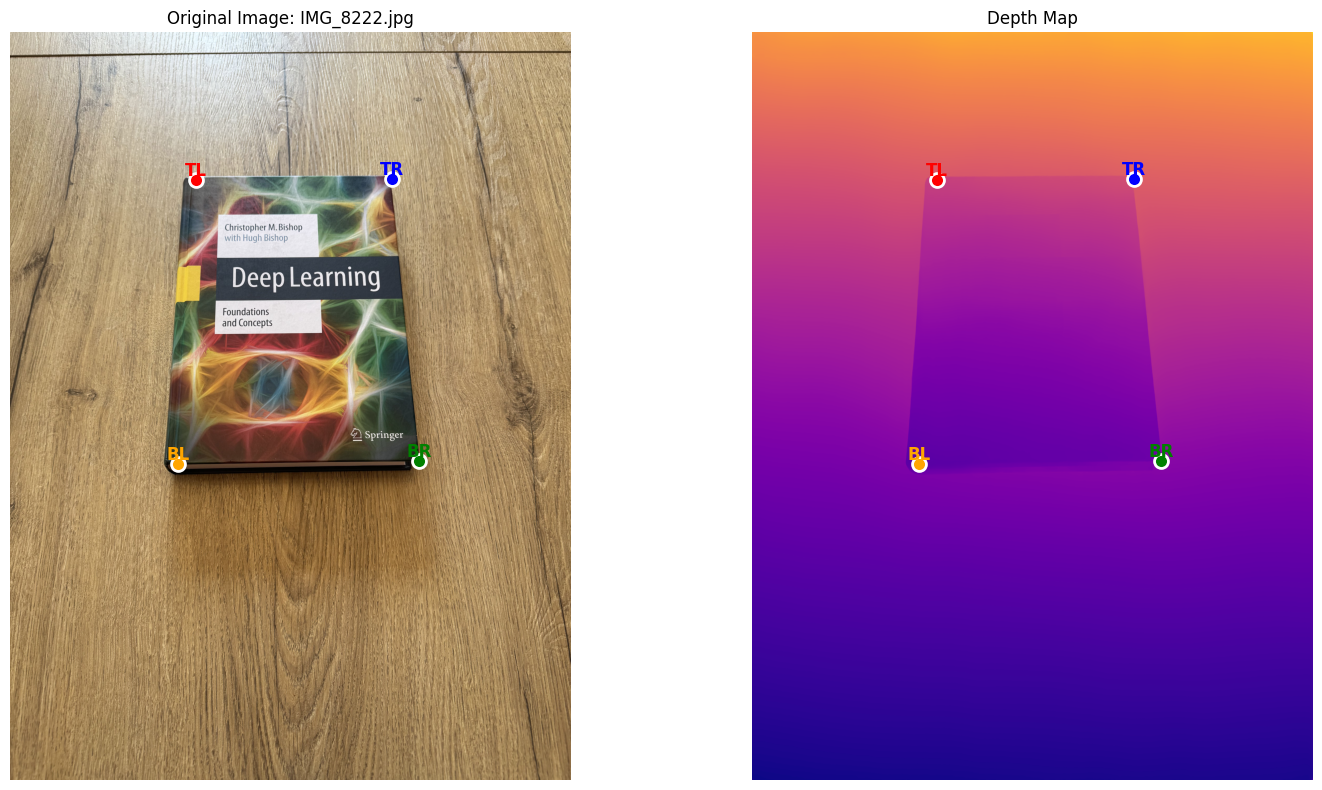


Depth values for IMG_8222.jpg:
  TL: 0.735m
  TR: 0.784m
  BR: 0.638m
  BL: 0.578m


In [4]:
# Visualize the first image as an example
image_name = 'IMG_8222.jpg'
corners_csv_path = os.path.join(project_root, 'assets', 'colmap', 'book_corners_labels.csv')
image_dir = os.path.join(project_root, 'assets', 'colmap', 'images')
depth_maps_dir = os.path.join(project_root, 'assets', 'colmap', 'depth_maps')
focal_lengths_path = os.path.join(project_root, 'assets', 'colmap', 'focal_lengths.npy')
focal_lengths = np.load(focal_lengths_path, allow_pickle=True)

visualize_book_depth(image_name, corners_csv_path, image_dir, depth_maps_dir)

In [5]:
def visualize_book_depth_v2(image_name, corners_csv_path, images_dir, depth_maps_dir):
    """
    Visualize image and depth map with book corners annotated
    
    Args:
        image_name: e.g. 'IMG_8222.jpg'
        corners_csv_path: path to CSV file with corner coordinates
        images_dir: directory containing original images
        depth_maps_dir: directory containing depth map .npy files
    """
    
    # Load corner coordinates
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name]
    
    if len(row) == 0:
        print(f"Image {image_name} not found in CSV")
        return
    
    row = row.iloc[0]
    corners = [
        (row['top_left_x'], row['top_left_y']),
        (row['top_right_x'], row['top_right_y']),
        (row['bottom_right_x'], row['bottom_right_y']),
        (row['bottom_left_x'], row['bottom_left_y'])
    ]
    corner_labels = ['TL', 'TR', 'BR', 'BL']
    
    # Load image and depth map
    image_path = f"{images_dir}/{image_name}"
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    
    image = Image.open(image_path)
    depth_map = np.load(depth_path)

    # Apply EXIF rotation explicitly
    image = ImageOps.exif_transpose(image)
    
    # Create side-by-side plot with minimal spacing
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Reduce spacing between subplots
    plt.subplots_adjust(wspace=-0.5)  # Minimal white space between images
    
    # Original image with corners
    ax1.imshow(image, origin='upper')
    ax1.axis('off')
    
    # Depth map with corners
    # If width > height, rotate the depth map for correct orientation
    if depth_map.shape[1] > depth_map.shape[0]:
        depth_map = depth_map.T
    # Flip horizontally to match image orientation
    depth_map = np.fliplr(depth_map)
    ax2.imshow(depth_map, cmap='plasma')
    ax2.axis('off')
    
    # Enhanced visual markers
    colors = ['#FF3333', '#3366FF', '#33FF33', '#FF9933']  # More vibrant colors
    marker_size = 8
    edge_width = 2
    font_size = 14
    depths = []
    offsets = [(-180, -180), (180, -180), (180, 180), (-180, 180)]  # Offset for text labels
    
    for _, ((x, y), label, color, offset) in enumerate(zip(corners, corner_labels, colors, offsets)):
        # Get depth value
        depth = depth_map[int(y), int(x)]
        depths.append(depth)

        # Get offset positions
        offset_x, offset_y = offset
        
        # Enhanced markers on both images
        # Use different marker styles for better visibility
        ax1.plot(x, y, 'o', color=color, markersize=marker_size, 
                markeredgecolor='white', markeredgewidth=edge_width, alpha=0.9)
        ax1.text(x + offset_x, y + offset_y, label, color='white', fontsize=font_size, fontweight='bold', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8, edgecolor='white'))
        
        ax2.plot(x, y, 'o', color=color, markersize=marker_size, 
                markeredgecolor='white', markeredgewidth=edge_width, alpha=0.9)
        ax2.text(x + offset_x, y + offset_y, label, color='white', fontsize=font_size, fontweight='bold', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8, edgecolor='white'))
    
    # Remove any padding around the images
    ax1.set_xlim(0, image.width)
    ax1.set_ylim(image.height, 0)  # Inverted y-axis for image coordinates
    ax2.set_xlim(0, depth_map.shape[1])
    ax2.set_ylim(depth_map.shape[0], 0)  # Inverted y-axis for image coordinates
    
    plt.tight_layout(pad=0.1)  # Minimal padding
    plt.show()
    
    # Print depths with better formatting
    print(f"\nDepth values for {image_name}:")
    print("-" * 25)
    for label, depth in zip(corner_labels, depths):
        print(f"  {label}: {depth:.3f}m")
    print("-" * 25)

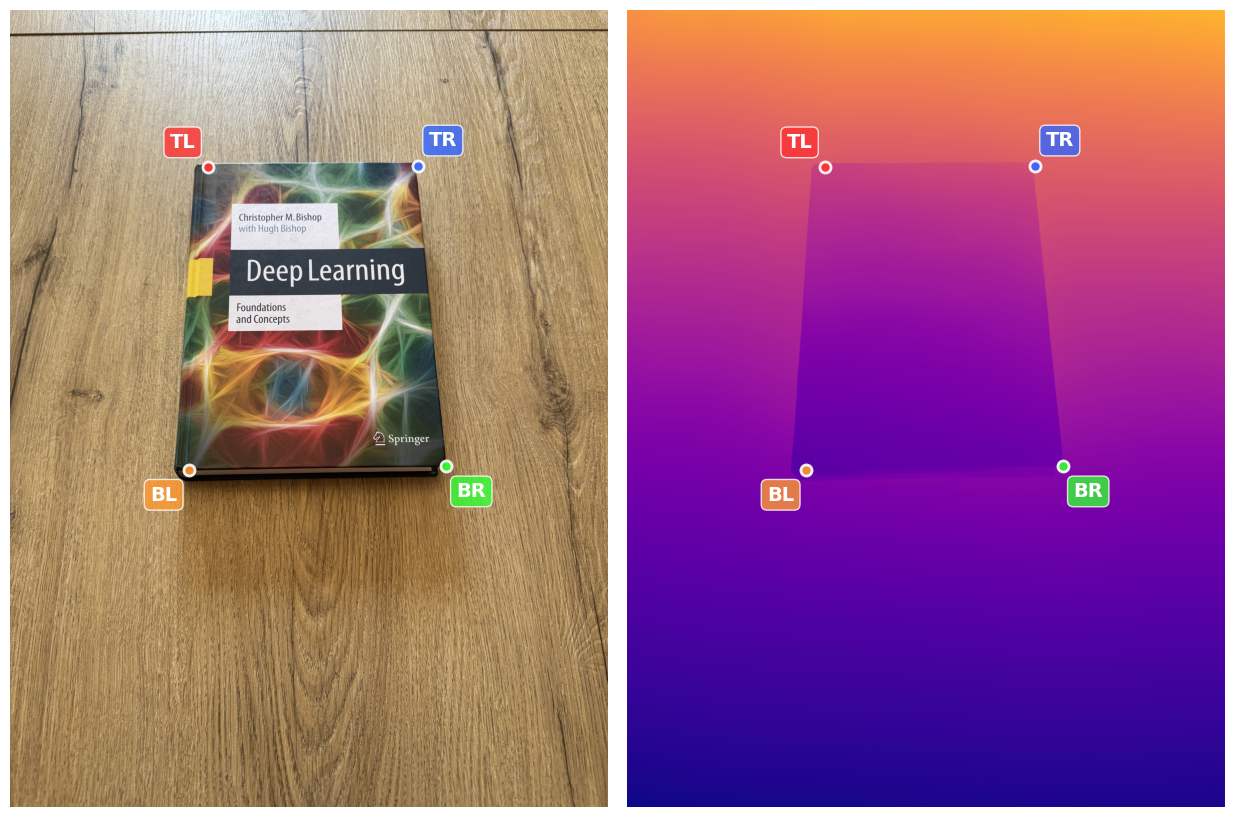


Depth values for IMG_8222.jpg:
-------------------------
  TL: 0.735m
  TR: 0.784m
  BR: 0.638m
  BL: 0.578m
-------------------------


In [6]:
visualize_book_depth_v2(image_name, corners_csv_path, image_dir, depth_maps_dir)

In [7]:
def visualize_book_depth_overlay(image_name, corners_csv_path, images_dir, depth_maps_dir, 
                                overlay_type='transparency', alpha=0.5):
    """
    Visualize image with depth map overlaid using various methods
    
    Args:
        image_name: e.g. 'IMG_8222.jpg'
        corners_csv_path: path to CSV file with corner coordinates
        images_dir: directory containing original images
        depth_maps_dir: directory containing depth map .npy files
        overlay_type: 'transparency', 'contours', 'colorized', 'heatmap'
        alpha: transparency level (0-1) for overlay methods
    """
    
    # Load corner coordinates
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name]
    
    if len(row) == 0:
        print(f"Image {image_name} not found in CSV")
        return
    
    row = row.iloc[0]
    corners = [
        (row['top_left_x'], row['top_left_y']),
        (row['top_right_x'], row['top_right_y']),
        (row['bottom_right_x'], row['bottom_right_y']),
        (row['bottom_left_x'], row['bottom_left_y'])
    ]
    corner_labels = ['TL', 'TR', 'BR', 'BL']
    
    # Load image and depth map
    image_path = f"{images_dir}/{image_name}"
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    
    image = Image.open(image_path)
    depth_map = np.load(depth_path)

    # Apply EXIF rotation explicitly
    image = ImageOps.exif_transpose(image)
    image_array = np.array(image)
    
    # Process depth map
    if depth_map.shape[1] > depth_map.shape[0]:
        depth_map = depth_map.T
    depth_map = np.fliplr(depth_map)
    
    # Resize depth map to match image if necessary
    from scipy.ndimage import zoom
    if depth_map.shape != image_array.shape[:2]:
        scale_y = image_array.shape[0] / depth_map.shape[0]
        scale_x = image_array.shape[1] / depth_map.shape[1]
        depth_map = zoom(depth_map, (scale_y, scale_x), order=1)
    
    # Normalize depth map for better visualization
    depth_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    if overlay_type == 'transparency':
        # Simple transparency overlay
        ax.imshow(image_array, origin='upper')
        im = ax.imshow(depth_map, cmap='plasma', alpha=alpha, origin='upper')
        plt.colorbar(im, ax=ax, label='Depth (m)', shrink=0.8)
    
    elif overlay_type == 'contours':
        # Contour lines over original image
        ax.imshow(image_array, origin='upper')
        contours = ax.contour(depth_map, levels=30, colors='white', linewidths=1.5, alpha=0.8)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')
    
    elif overlay_type == 'colorized':
        # Depth-based colorization of the image
        # Convert image to HSV and modify the value channel based on depth
        from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
        
        # Normalize image to 0-1 range
        image_norm = image_array.astype(float) / 255.0
        
        # Convert to HSV
        hsv = rgb_to_hsv(image_norm)
        
        # Modulate the brightness (V channel) based on depth
        # Closer objects (higher depth values) are brighter
        depth_factor = 0.5 + 0.5 * depth_norm  # Scale to 0.5-1.0 range
        hsv[:,:,2] = hsv[:,:,2] * depth_factor
        
        # Convert back to RGB
        modified_image = hsv_to_rgb(hsv)
        ax.imshow(modified_image, origin='upper')
        
        # Add a colorbar showing the depth scale
        im = ax.imshow(depth_map, cmap='plasma', alpha=0, origin='upper')
        plt.colorbar(im, ax=ax, label='Depth (m)', shrink=0.8)
    
    elif overlay_type == 'heatmap':
        # Semi-transparent heatmap overlay
        ax.imshow(image_array, origin='upper')
        
        # Create a masked version where only certain depth ranges are shown
        depth_threshold = np.percentile(depth_map, 25)  # Show closest 75% of depths
        masked_depth = np.ma.masked_where(depth_map > depth_threshold, depth_map)
        
        im = ax.imshow(masked_depth, cmap='hot', alpha=alpha, origin='upper')
        plt.colorbar(im, ax=ax, label='Close Objects Depth (m)', shrink=0.8)
    
    else:
        print(f"Unknown overlay_type: {overlay_type}")
        return
    
    ax.axis('off')
    
    # Enhanced visual markers
    colors = ['#FF3333', '#3366FF', '#33FF33', '#FF9933']
    marker_size = 14
    edge_width = 3
    font_size = 12
    depths = []
    
    for _, ((x, y), label, color) in enumerate(zip(corners, corner_labels, colors)):
        # Get depth value
        if 0 <= int(y) < depth_map.shape[0] and 0 <= int(x) < depth_map.shape[1]:
            depth = depth_map[int(y), int(x)]
            depths.append(depth)
            
            # Enhanced markers
            ax.plot(x, y, 'o', color=color, markersize=marker_size, 
                   markeredgecolor='black', markeredgewidth=edge_width, alpha=0.9)
            ax.text(x, y-35, label, color='white', fontsize=font_size, fontweight='bold', 
                   ha='center', va='center', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.8, edgecolor='white'))
    
    ax.set_xlim(0, image_array.shape[1])
    ax.set_ylim(image_array.shape[0], 0)
    
    plt.tight_layout()
    plt.show()
    
    # Print depths
    if depths:
        print(f"\nDepth values for {image_name} ({overlay_type} overlay):")
        print("-" * 35)
        for label, depth in zip(corner_labels, depths):
            print(f"  {label}: {depth:.3f}m")
        print("-" * 35)

# Convenience function to try all overlay types
def compare_overlay_methods(image_name, corners_csv_path, images_dir, depth_maps_dir):
    """Compare different overlay visualization methods"""
    
    overlay_types = ['transparency', 'contours', 'colorized', 'heatmap']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Depth Overlay Comparison: {image_name}', fontsize=16, fontweight='bold')
    
    # Load data once
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name].iloc[0]
    corners = [
        (row['top_left_x'], row['top_left_y']),
        (row['top_right_x'], row['top_right_y']),
        (row['bottom_right_x'], row['bottom_right_y']),
        (row['bottom_left_x'], row['bottom_left_y'])
    ]
    
    image_path = f"{images_dir}/{image_name}"
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image_array = np.array(image)
    
    depth_map = np.load(depth_path)
    if depth_map.shape[1] > depth_map.shape[0]:
        depth_map = depth_map.T
    depth_map = np.fliplr(depth_map)
    
    # Resize depth map if necessary
    from scipy.ndimage import zoom
    if depth_map.shape != image_array.shape[:2]:
        scale_y = image_array.shape[0] / depth_map.shape[0]
        scale_x = image_array.shape[1] / depth_map.shape[1]
        depth_map = zoom(depth_map, (scale_y, scale_x), order=1)
    
    axes = axes.ravel()
    
    for i, overlay_type in enumerate(overlay_types):
        ax = axes[i]
        ax.set_title(overlay_type.capitalize(), fontweight='bold')
        
        if overlay_type == 'transparency':
            ax.imshow(image_array, origin='upper')
            ax.imshow(depth_map, cmap='plasma', alpha=0.5, origin='upper')
        
        elif overlay_type == 'contours':
            ax.imshow(image_array, origin='upper')
            ax.contour(depth_map, levels=30, colors='white', linewidths=1, alpha=0.8)
        
        elif overlay_type == 'colorized':
            from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
            image_norm = image_array.astype(float) / 255.0
            hsv = rgb_to_hsv(image_norm)
            depth_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
            depth_factor = 0.5 + 0.5 * depth_norm
            hsv[:,:,2] = hsv[:,:,2] * depth_factor
            modified_image = hsv_to_rgb(hsv)
            ax.imshow(modified_image, origin='upper')
        
        elif overlay_type == 'heatmap':
            ax.imshow(image_array, origin='upper')
            depth_threshold = np.percentile(depth_map, 75)
            masked_depth = np.ma.masked_where(depth_map > depth_threshold, depth_map)
            ax.imshow(masked_depth, cmap='hot', alpha=0.6, origin='upper')
        
        # Add corner markers
        colors = ['#FF3333', '#3366FF', '#33FF33', '#FF9933']
        for (x, y), color in zip(corners, colors):
            ax.plot(x, y, 'o', color=color, markersize=8, 
                   markeredgecolor='white', markeredgewidth=2)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

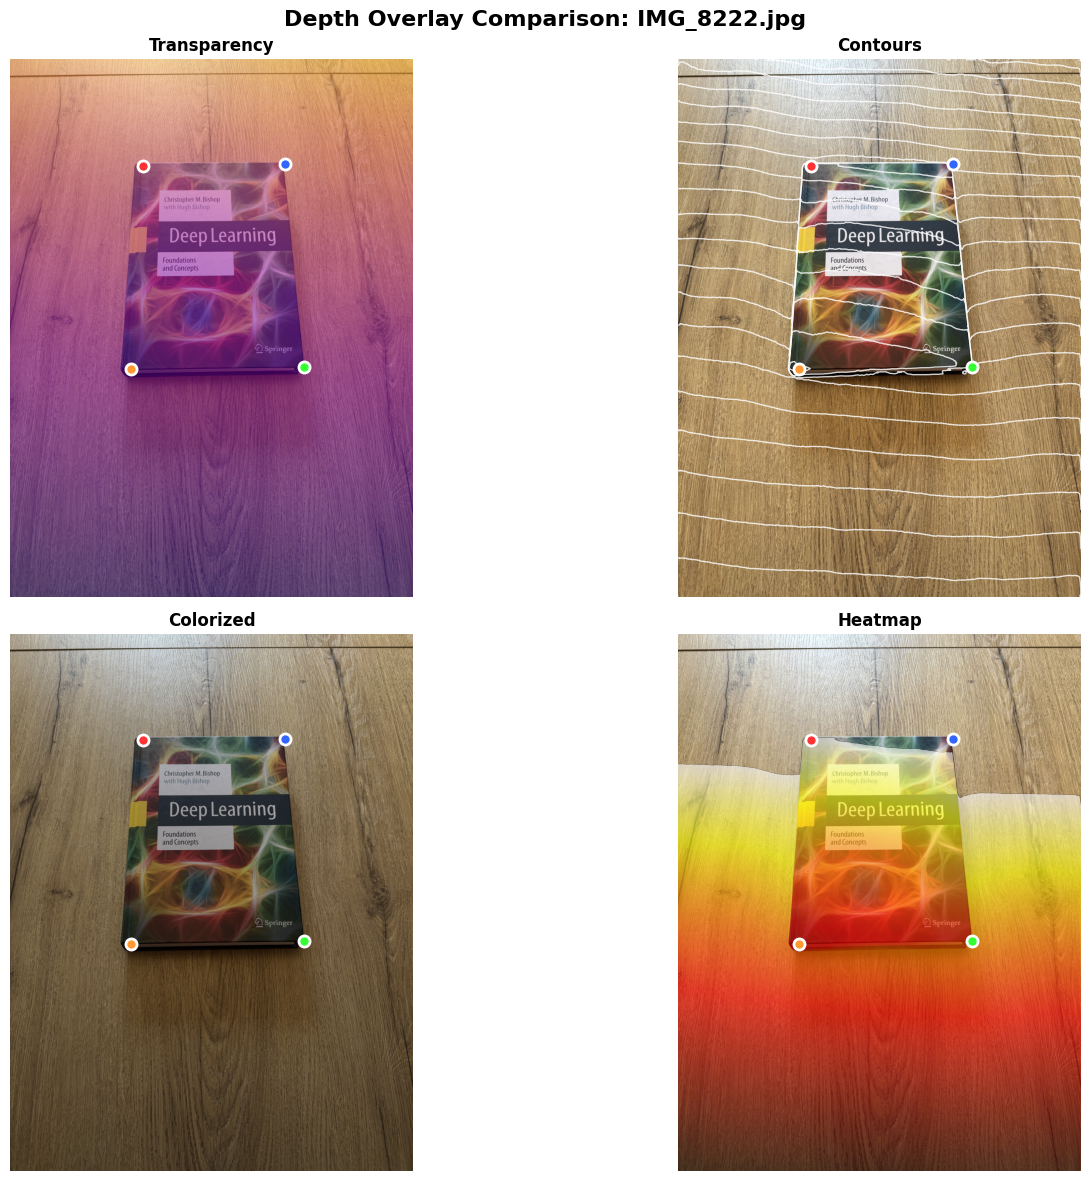

In [8]:
compare_overlay_methods(image_name, corners_csv_path, image_dir, depth_maps_dir)

In [9]:
def estimate_camera_pose(image_name, corners_csv_path, depth_maps_dir, 
                        book_width_m=0.21, book_height_m=0.297):
    """
    Estimate camera pose using book corners as reference points
    
    Args:
        image_name: e.g. 'IMG_8222.jpg'
        corners_csv_path: path to CSV with corner coordinates
        depth_maps_dir: directory with depth .npy files
        book_width_m: actual book width in meters (A4 = 0.21m)
        book_height_m: actual book height in meters (A4 = 0.297m)
    
    Returns:
        rotation_vector, translation_vector, rotation_matrix
    """
    
    # Load corner coordinates from CSV
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name].iloc[0]
    
    # Extract 2D corner coordinates (in image pixels)
    corners_2d = np.array([
        [row['top_left_x'], row['top_left_y']],
        [row['top_right_x'], row['top_right_y']], 
        [row['bottom_right_x'], row['bottom_right_y']],
        [row['bottom_left_x'], row['bottom_left_y']]
    ], dtype=np.float32)
    
    # Load depth map and get 3D coordinates
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    depth_map = np.load(depth_path).T  # Transpose to match image orientation
    
    # Load focal length
    focal_length = 5152.22
    
    # Get image center (assuming it's at the center)
    image_height, image_width = depth_map.shape
    cx = image_width / 2
    cy = image_height / 2
    
    # Camera intrinsic matrix
    K = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ], dtype=np.float32)
    
    # Get 3D world coordinates of book corners (assuming book lies flat)
    # Define book corners in book's local coordinate system
    corners_3d_book = np.array([
        [0, 0, 0],                          # top-left
        [book_width_m, 0, 0],               # top-right
        [book_width_m, book_height_m, 0],   # bottom-right
        [0, book_height_m, 0]               # bottom-left
    ], dtype=np.float32)
    
    # Solve PnP to get camera pose relative to book
    success, rvec, tvec = cv2.solvePnP(
        corners_3d_book,  # 3D points in world (book) coordinates
        corners_2d,       # 2D points in image coordinates  
        K,               # Camera intrinsic matrix
        None             # No distortion coefficients
    )
    
    if not success:
        print("PnP solving failed!")
        return None, None, None
    
    R = cv2.Rodrigues(rvec)[0]

    return rvec, tvec, R, K

def visualize_pose_with_axes(image_path, corners_2d, K, rvec, tvec, axis_length=0.1):
    """
    Visualize camera pose by projecting 3D axes onto the image
    """
    # 3D points for coordinate axes
    axes_3d = np.array([
        [0, 0, 0],           # origin
        [axis_length, 0, 0], # x-axis (red)
        [0, axis_length, 0], # y-axis (green) 
        [0, 0, axis_length]  # z-axis (blue)
    ], dtype=np.float32)
    
    # Project 3D axes to 2D
    axes_2d, _ = cv2.projectPoints(axes_3d, rvec, tvec, K, None)
    axes_2d = axes_2d.reshape(-1, 2)
    
    # Load and display image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    # Draw book corners
    colors = ['red', 'blue', 'green', 'orange']
    labels = ['TL', 'TR', 'BR', 'BL']
    for i, ((x, y), color, label) in enumerate(zip(corners_2d, colors, labels)):
        plt.plot(x, y, 'o', color=color, markersize=8, markeredgecolor='white', markeredgewidth=2)
        plt.text(x, y-30, label, color=color, fontsize=12, fontweight='bold', ha='center')
    
    # Draw coordinate axes
    origin = axes_2d[0]
    x_axis = axes_2d[1]
    y_axis = axes_2d[2] 
    z_axis = axes_2d[3]
    
    plt.arrow(origin[0], origin[1], x_axis[0]-origin[0], x_axis[1]-origin[1], 
              head_width=20, head_length=30, fc='red', ec='red', linewidth=3)
    plt.arrow(origin[0], origin[1], y_axis[0]-origin[0], y_axis[1]-origin[1],
              head_width=20, head_length=30, fc='green', ec='green', linewidth=3)
    plt.arrow(origin[0], origin[1], origin[0]-z_axis[0], origin[1]-z_axis[1],
              head_width=20, head_length=30, fc='blue', ec='blue', linewidth=3)
    
    plt.title("Camera Pose Visualization")
    plt.axis('off')
    plt.show()

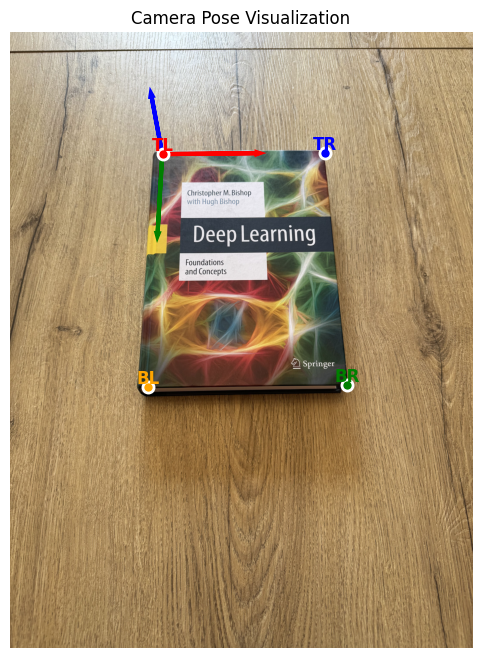

In [10]:
# Estimate pose for one image
rvec, tvec, R, K = estimate_camera_pose(
    image_name, 
    corners_csv_path,
    depth_maps_dir,
    book_width_m=0.173,
    book_height_m=0.26
)

if rvec is not None:
    # Load corners for visualization
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name].iloc[0]
    corners_2d = np.array([
        [row['top_left_x'], row['top_left_y']],
        [row['top_right_x'], row['top_right_y']], 
        [row['bottom_right_x'], row['bottom_right_y']],
        [row['bottom_left_x'], row['bottom_left_y']]
    ], dtype=np.float32)
    
    # Visualize the pose
    visualize_pose_with_axes(os.path.join(image_dir, image_name), corners_2d, K, rvec, tvec)

In [23]:
def get_plane_normal_from_corners(corners_2d, depth_map, focal_length, image_width, image_height):
    """
    Fit a plane to the 4 book corners and return its normal vector
    
    Args:
        corners_2d: array of shape (4, 2) with pixel coordinates
        depth_map: 2D numpy array with depth values
        focal_length: camera focal length in pixels
        image_width, image_height: image dimensions
    
    Returns:
        normal_vector: unit normal vector of the fitted plane
        corners_3d: 3D coordinates of the corners
    """
    
    # Camera parameters
    cx = image_width / 2
    cy = image_height / 2
    
    # Convert 2D corners to 3D using depth
    corners_3d = []
    for x, y in corners_2d:
        depth = depth_map[int(y), int(x)]
        # Convert to 3D camera coordinates
        x_3d = (x - cx) * depth / focal_length
        y_3d = (y - cy) * depth / focal_length
        z_3d = depth
        corners_3d.append([x_3d, y_3d, z_3d])
    
    corners_3d = np.array(corners_3d)
    
    # Fit plane using SVD (simplest method)
    # Center the points
    centroid = np.mean(corners_3d, axis=0)
    centered_points = corners_3d - centroid
    
    # SVD to find the normal (smallest singular vector)
    U, S, Vt = np.linalg.svd(centered_points)
    normal = Vt[-1]  # Last row of Vt is the normal vector
    
    # Ensure normal points towards camera (positive Z in camera coords)
    if normal[2] < 0:
        normal = -normal
    
    return normal, corners_3d, centroid

def plot_plane_and_normal(image_path, corners_2d, normal, centroid, focal_length, 
                                   image_width, image_height, ground_truth_z_axis=None, axis_length=0.8):
    """
    Plot the plane normal and ground truth Z-axis projected onto the original image
    """
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    
    # Camera intrinsic matrix
    cx = image_width / 2
    cy = image_height / 2
    
    # Project centroid to 2D
    centroid_2d = np.array([
        centroid[0] * focal_length / centroid[2] + cx,
        centroid[1] * focal_length / centroid[2] + cy
    ])
    
    # Project normal vector endpoint to 2D
    normal_end_3d = centroid + normal * axis_length
    normal_end_2d = np.array([
        normal_end_3d[0] * focal_length / normal_end_3d[2] + cx,
        normal_end_3d[1] * focal_length / normal_end_3d[2] + cy
    ])
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    # Draw book corners
    colors = ['red', 'blue', 'green', 'orange']
    labels = ['TL', 'TR', 'BR', 'BL']
    for i, ((x, y), color, label) in enumerate(zip(corners_2d, colors, labels)):
        plt.plot(x, y, 'o', color=color, markersize=8, markeredgecolor='white', markeredgewidth=2)
        plt.text(x, y-30, label, color=color, fontsize=12, fontweight='bold', ha='center')
    
    # Draw plane normal
    plt.arrow(centroid_2d[0], centroid_2d[1], 
              centroid_2d[0] - normal_end_2d[0], centroid_2d[1] - normal_end_2d[1],
              head_width=20, head_length=30, fc='black', ec='black', linewidth=2, label='Plane Normal')
    
    # Draw ground truth Z-axis if provided
    if ground_truth_z_axis is not None:
        gt_end_3d = centroid + ground_truth_z_axis * axis_length
        gt_end_2d = np.array([
            gt_end_3d[0] * focal_length / gt_end_3d[2] + cx,
            gt_end_3d[1] * focal_length / gt_end_3d[2] + cy
        ])
        
        plt.arrow(centroid_2d[0], centroid_2d[1],
                  centroid_2d[0] - gt_end_2d[0], centroid_2d[1] - gt_end_2d[1],
                  head_width=20, head_length=30, fc='purple', ec='purple', linewidth=2,
                  linestyle='--', alpha=0.8, label='Ground Truth Z')
    
    plt.title("Plane Normal vs Ground Truth Z-axis")
    plt.axis('off')
    plt.legend()
    plt.show()
    
    # Print comparison
    if ground_truth_z_axis is not None:
        dot_product = np.dot(normal, ground_truth_z_axis)
        angle_degrees = np.degrees(np.arccos(np.clip(dot_product, -1, 1)))
        print("\nComparison:")
        print(f"Plane normal:     [{normal[0]:.4f}, {normal[1]:.4f}, {normal[2]:.4f}]")
        print(f"Ground truth Z:   [{ground_truth_z_axis[0]:.4f}, {ground_truth_z_axis[1]:.4f}, {ground_truth_z_axis[2]:.4f}]")
        print(f"Angle difference: {angle_degrees:.2f} degrees")
        print(f"Dot product:      {dot_product:.4f}")

def analyze_book_plane(image_name, corners_csv_path, depth_maps_dir, ground_truth_R=None):
    """
    Complete analysis: load data, fit plane, compare to ground truth
    """
    # Load corner coordinates
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name].iloc[0]
    corners_2d = np.array([
        [row['top_left_x'], row['top_left_y']],
        [row['top_right_x'], row['top_right_y']], 
        [row['bottom_right_x'], row['bottom_right_y']],
        [row['bottom_left_x'], row['bottom_left_y']]
    ], dtype=np.float32)
    
    # Load depth map
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    depth_map = np.load(depth_path).T
    
    # Load focal length
    focal_length = 4155.88
    
    # Get image dimensions
    image_height, image_width = depth_map.shape
    
    # Fit plane and get normal
    normal, corners_3d, centroid = get_plane_normal_from_corners(
        corners_2d, depth_map, focal_length, image_width, image_height)
    
    # Extract ground truth Z-axis from rotation matrix if provided
    ground_truth_z = None
    if ground_truth_R is not None:
        # Z-axis is the 3rd column of the rotation matrix
        ground_truth_z = ground_truth_R[:, 2]
    
    # Plot and compare
    plot_plane_and_normal(
        os.path.join(image_dir, image_name),
        corners_2d, normal, centroid, focal_length, 
        image_width, image_height, ground_truth_z
    )
    
    return ground_truth_z, normal, corners_3d, centroid

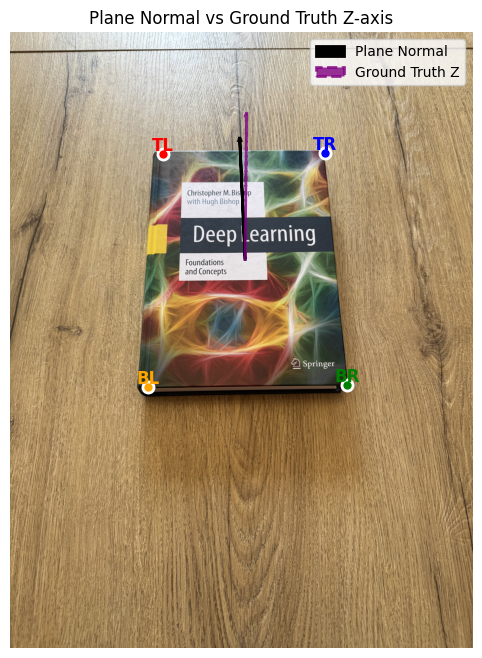


Comparison:
Plane normal:     [0.0300, 0.3085, 0.9507]
Ground truth Z:   [0.0026, 0.4028, 0.9153]
Angle difference: 5.99 degrees
Dot product:      0.9945


In [24]:
ground_truth_z, normal, corners_3d, centroid = analyze_book_plane(
    image_name, 
    corners_csv_path,
    depth_maps_dir, 
    R
)

In [31]:
def plot_plane_and_normal_v2(image_path, corners_2d, normal, centroid, focal_length, 
                          image_width, image_height, ground_truth_z_axis=None, axis_length=0.8):
    """
    Enhanced plot of plane normal and ground truth Z-axis projected onto the original image
    """
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    
    # Camera intrinsic matrix
    cx = image_width / 2
    cy = image_height / 2
    
    # Project centroid to 2D
    centroid_2d = np.array([
        centroid[0] * focal_length / centroid[2] + cx,
        centroid[1] * focal_length / centroid[2] + cy
    ])
    
    # Project normal vector endpoint to 2D
    normal_end_3d = centroid + normal * axis_length
    normal_end_2d = np.array([
        normal_end_3d[0] * focal_length / normal_end_3d[2] + cx,
        normal_end_3d[1] * focal_length / normal_end_3d[2] + cy
    ])
    
    # Create figure with better proportions
    plt.figure(figsize=(10, 8))
    plt.imshow(image, origin='upper')
    
    # Enhanced book corners with consistent styling from your v2 function
    colors = ['#FF3333', '#3366FF', '#33FF33', '#FF9933']
    labels = ['TL', 'TR', 'BR', 'BL']
    marker_size = 8
    edge_width = 2
    font_size = 14
    
    # Calculate smart offsets for corner labels to avoid overlap
    offsets = [(-180, -180), (180, -180), (180, 180), (-180, 180)]
    
    for i, ((x, y), color, label, offset) in enumerate(zip(corners_2d, colors, labels, offsets)):
        offset_x, offset_y = offset
        
        plt.plot(x, y, 'o', color=color, markersize=marker_size, 
                markeredgecolor='white', markeredgewidth=edge_width, alpha=0.9)
        plt.text(x + offset_x, y + offset_y, label, color='white', fontsize=font_size, fontweight='bold', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.9, edgecolor='white', linewidth=1.5))
    
    # Draw plane normal with enhanced styling (using same logic as your plt.arrow)
    arrow_dx = centroid_2d[0] - normal_end_2d[0]
    arrow_dy = centroid_2d[1] - normal_end_2d[1]
    plt.annotate('', xy=(centroid_2d[0] + arrow_dx, centroid_2d[1] + arrow_dy), 
                xytext=(centroid_2d[0], centroid_2d[1]),
                arrowprops=dict(arrowstyle='->', color='black', lw=4, 
                               mutation_scale=25, alpha=0.9))
    
    # Add label for plane normal
    mid_normal_x = centroid_2d[0] + arrow_dx/2
    mid_normal_y = centroid_2d[1] + arrow_dy/2
    plt.text(mid_normal_x - 1600, mid_normal_y + 50, 'Estimated Normal', 
            fontsize=14, fontweight='bold', color='black',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='black'))
    
    # Draw ground truth Z-axis if provided
    if ground_truth_z_axis is not None:
        gt_end_3d = centroid + ground_truth_z_axis * axis_length
        gt_end_2d = np.array([
            gt_end_3d[0] * focal_length / gt_end_3d[2] + cx,
            gt_end_3d[1] * focal_length / gt_end_3d[2] + cy
        ])
        
        # Use same arrow direction logic as your plt.arrow
        gt_arrow_dx = centroid_2d[0] - gt_end_2d[0]
        gt_arrow_dy = centroid_2d[1] - gt_end_2d[1]
        plt.annotate('', xy=(centroid_2d[0] + gt_arrow_dx, centroid_2d[1] + gt_arrow_dy), 
                    xytext=(centroid_2d[0], centroid_2d[1]),
                    arrowprops=dict(arrowstyle='->', color='#FF6B35', lw=4, 
                                   mutation_scale=25, alpha=0.8, linestyle='--'))
        
        # Add label for ground truth
        mid_gt_x = centroid_2d[0] + gt_arrow_dx/2
        mid_gt_y = centroid_2d[1] + gt_arrow_dy/2
        plt.text(mid_gt_x + 150, mid_gt_y + 50, 'Ground Truth', 
                fontsize=14, fontweight='bold', color='#FF6B35',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='#FF6B35'))
    
    # Mark centroid point
    plt.plot(centroid_2d[0], centroid_2d[1], 'o', color='#F7EBDE', markersize=8, 
            markeredgecolor='black', markeredgewidth=2, alpha=0.9, zorder=10)
    
    plt.axis('off')
    
    # Set proper limits to ensure everything is visible
    plt.xlim(0, image.width)
    plt.ylim(image.height, 0)
    
    plt.tight_layout()
    plt.show()
    
    # Enhanced comparison output
    if ground_truth_z_axis is not None:
        dot_product = np.dot(normal, ground_truth_z_axis)
        angle_degrees = np.degrees(np.arccos(np.clip(dot_product, -1, 1)))
        
        print("\n" + "="*50)
        print("PLANE NORMAL ANALYSIS")
        print("="*50)
        print(f"Estimated Normal: [{normal[0]:+.4f}, {normal[1]:+.4f}, {normal[2]:+.4f}]")
        print(f"Ground Truth Z:   [{ground_truth_z_axis[0]:+.4f}, {ground_truth_z_axis[1]:+.4f}, {ground_truth_z_axis[2]:+.4f}]")
        print("-"*50)
        print(f"Angular Error:    {angle_degrees:.2f}°")
        print(f"Dot Product:      {dot_product:+.4f}")
        print(f"Alignment Score:  {abs(dot_product)*100:.1f}%")
        print("="*50)
    else:
        print("\n" + "="*30)
        print("ESTIMATED PLANE NORMAL")
        print("="*30)
        print(f"Normal Vector: [{normal[0]:+.4f}, {normal[1]:+.4f}, {normal[2]:+.4f}]")
        print(f"Magnitude:     {np.linalg.norm(normal):.4f}")
        print("="*30)


def analyze_book_plane_v2(image_name, corners_csv_path, depth_maps_dir, images_dir, ground_truth_R=None):
    """
    Enhanced complete analysis: load data, fit plane, compare to ground truth
    """
    # Load corner coordinates
    df = pd.read_csv(corners_csv_path)
    row = df[df['image_name'] == image_name].iloc[0]
    corners_2d = np.array([
        [row['top_left_x'], row['top_left_y']],
        [row['top_right_x'], row['top_right_y']], 
        [row['bottom_right_x'], row['bottom_right_y']],
        [row['bottom_left_x'], row['bottom_left_y']]
    ], dtype=np.float32)
    
    # Load depth map
    depth_path = f"{depth_maps_dir}/{image_name.replace('.jpg', '_map.npy')}"
    depth_map = np.load(depth_path).T
    
    # Load focal length
    focal_length = 4155.88
    
    # Get image dimensions
    image_height, image_width = depth_map.shape
    
    # Fit plane and get normal
    normal, corners_3d, centroid = get_plane_normal_from_corners(
        corners_2d, depth_map, focal_length, image_width, image_height)
    
    # Extract ground truth Z-axis from rotation matrix if provided
    ground_truth_z = None
    if ground_truth_R is not None:
        # Z-axis is the 3rd column of the rotation matrix
        ground_truth_z = ground_truth_R[:, 2]
    
    # Plot and compare with enhanced visualization
    image_path = f"{images_dir}/{image_name}"
    plot_plane_and_normal_v2(
        image_path, corners_2d, normal, centroid, focal_length, 
        image_width, image_height, ground_truth_z
    )
    
    return ground_truth_z, normal, corners_3d, centroid

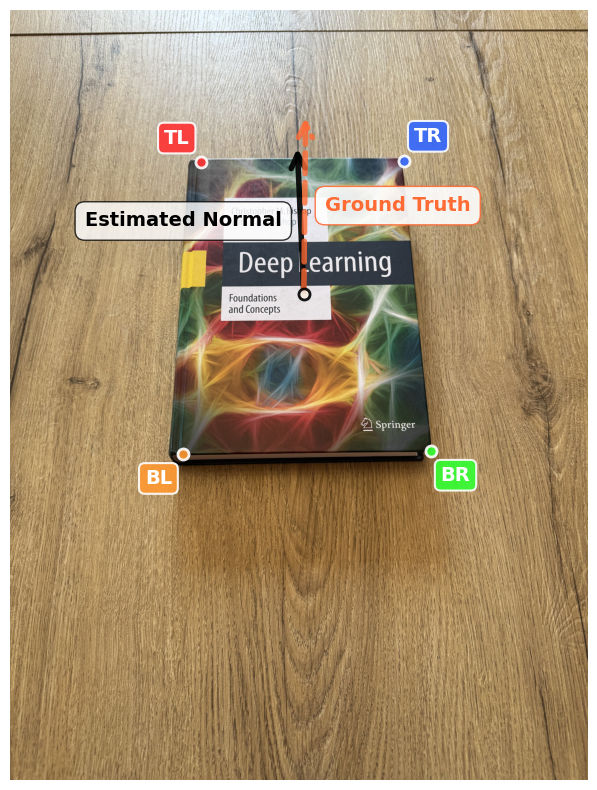


PLANE NORMAL ANALYSIS
Estimated Normal: [+0.0300, +0.3085, +0.9507]
Ground Truth Z:   [+0.0026, +0.4028, +0.9153]
--------------------------------------------------
Angular Error:    5.99°
Dot Product:      +0.9945
Alignment Score:  99.5%


(array([0.00257157, 0.40282418, 0.91527376]),
 array([0.02998878, 0.30852157, 0.9507445 ], dtype=float32),
 array([[-0.13229209, -0.3149464 ,  0.7583311 ],
        [ 0.13771458, -0.30742705,  0.7346923 ],
        [ 0.14832948,  0.0626213 ,  0.6271002 ],
        [-0.12895985,  0.06575305,  0.6224642 ]], dtype=float32),
 array([ 0.00619803, -0.12349978,  0.68564695], dtype=float32))

In [32]:
analyze_book_plane_v2(
    image_name, 
    corners_csv_path,
    depth_maps_dir, 
    image_dir,
    R
)

## **Pipeline**

In [9]:
data = load_measurements_from_yaml("../assets/measurements.yaml")

In [10]:
def template_match(
    scene: np.ndarray,
    templates: list[Template],
    extract_method: Literal['SIFT', 'ORB'] = 'SIFT',
    match_method: Literal['BF', 'FLANN'] = 'BF',
    min_match_count: int = 10,
) -> dict:
    """
    Perform multi-template matching on a scene image for the given templates.

    Args:
        scene (np.ndarray): The scene image.
        templates (list[Template]): List of template objects to match against the scene.
        extract_method (Literal['SIFT', 'ORB']): Feature extraction method.
        match_method (Literal['BF', 'FLANN']): Feature matching method.
        min_match_count (int): Minimum number of matches required to consider a valid match.

    Returns:
        np.ndarray: The image size of the scene.
        dict: A dictionary containing, indexed by template id. For each template:
            - 'homography': The computed homography matrix.
            - 'error': The reprojection error.
    """
    # Initialize the results dictionary
    results = {}

    # Extract its features and descriptors
    scene_keypoints, scene_descriptors = extract_features(scene, method=extract_method)

    # Drawing
    scene_image_copy = scene.copy()

    # Iterate over each template
    for template in templates:
        # Load the template image
        template_image = load_rgb(os.path.join(project_root, template.path))

        # Extract features and descriptors from the template
        template_keypoints, template_descriptors = extract_features(template_image, method=extract_method)

        # Match the descriptors between the scene and the template
        matches = match_descriptors(template_descriptors, scene_descriptors, method=match_method)

        # Check if enough matches are found
        if len(matches) <= min_match_count:
            print(f"Not enough matches found for template {template.id}.")
            continue
            
        # Compute the homography
        H_px, mask, error = compute_homography(template_keypoints, scene_keypoints, matches)

        # Derive the metric homography
        H_metric = derive_metric_homography(
            H_px=H_px,
            template_size_px=template_image.shape[:2],
            template_size_metric=(template.height, template.width),
        )

        # Remove the scene keypoints that were used as inliers in the homography computation
        inlier_indices = set()
        for i, match in enumerate(matches):
            if mask[i] == 1:  # This match was an inlier
                inlier_indices.add(match.queryIdx)  # queryIdx is the scene keypoint index

        # Keep only the keypoints that weren't used as inliers
        remaining_indices = [i for i in range(len(scene_keypoints)) if i not in inlier_indices]
        scene_keypoints = [scene_keypoints[i] for i in remaining_indices]
        scene_descriptors = scene_descriptors[remaining_indices]

        # Plot template contour on scene image
        template_h, template_w = template_image.shape[:2]
        template_corners = np.float32([[0, 0], [template_w, 0], [template_w, template_h], [0, template_h]]).reshape(-1, 1, 2)
        scene_corners = cv2.perspectiveTransform(template_corners, H_px)

        cv2.polylines(scene_image_copy, [np.int32(scene_corners)], True, (0, 255, 255), 3, cv2.LINE_AA)

        # Store the results
        results[template.id] = {
            'homography': H_metric,
            'error': error
        }

    return scene.shape[:2], results

def calibrate_camera(
    homographies: list[np.ndarray],
    image_size: np.ndarray
) -> np.ndarray:
    """
    Calibrate the camera using a set of homographies.
    For simplicity, only the focal length is estimated, based on the following assumptions:
    - zero skew
    - principal point at the image center
    - square pixels (fx = fy = f)

    Args:
        homographies (list[np.ndarray]): List of homographies.
        image_size (tuple[int, int]): Size of the image (height, width).
    
    Returns:
        np.ndarray: Estimated intrinsic camera matrix (3x3).
    """
    # Compute the principal point
    cx, cy = image_size[1] / 2, image_size[0] / 2

    # Initialize the calibration object
    calibration = CalibrationSimple()

    # Calibrate the camera
    calibration.add_homographies(homographies)
    return calibration.calibrate(principal_point=(cx, cy))

def refine_calibration(
    templates: list[Template],
    homographies: list[np.ndarray],
    image_size: np.ndarray,
    K_init: np.ndarray,
    resolution: int = 20,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Refine the camera intrinsics and estimate radial distortion parameters (k1, k2).

    Args:
        templates (list[Template]): List of template objects containing metric dimensions.
        homographies (list[np.ndarray]): List of homographies for the scene.
        image_size (np.ndarray): Size of the image (width, height).
        K_init (np.ndarray): Initial intrinsic matrix (3x3).
        resolution (int): Resolution for the grid of points used for each template.

    Returns:
        tuple: Refined intrinsic matrix (3x3) and radial distortion parameters (1D array).
    """
    # Define the world points and the corresponding image points for each template
    object_points = []
    image_points = []
    for template, H in zip(templates, homographies):
        # Get template metric dimensions
        w, h = template.width, template.height

        # Define grid points on the template
        x = np.linspace(0, w, resolution)
        y = np.linspace(0, h, resolution)
        X, Y = np.meshgrid(x, y)

        # Create world points
        object_points_3d = np.array([
            [x, y, 0] for x, y, in zip(X.flatten(), Y.flatten())
        ], dtype=np.float32)

        # Create image points
        image_points_2d = cv2.perspectiveTransform(
            object_points_3d[:, :2].reshape(-1, 1, 2), H
        ).reshape(-1, 2)

        # Add these points to the lists
        object_points.append(object_points_3d)
        image_points.append(image_points_2d)

    # Initialize the distortion coefficients to zero
    dist_coeffs_init = np.zeros(5, dtype=np.float32)

    # Define the flags for the optimization
    flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS |
        cv2.CALIB_FIX_PRINCIPAL_POINT |
        cv2.CALIB_FIX_ASPECT_RATIO |
        cv2.CALIB_ZERO_TANGENT_DIST |
        cv2.CALIB_FIX_K3 |
        cv2.CALIB_FIX_K4 |
        cv2.CALIB_FIX_K5 |
        cv2.CALIB_FIX_K6
    )

    # Refine the intrinsic parameters and distortion coefficients
    ret, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        objectPoints=object_points,
        imagePoints=image_points,
        imageSize=image_size,
        cameraMatrix=K_init,
        distCoeffs=dist_coeffs_init,
        flags=flags
    )

    if not ret:
        raise RuntimeError("Camera calibration failed. Check the input data and parameters.")
    
    # Return the refined intrinsic matrix and distortion coefficients
    return K, dist_coeffs[:2]

def analyze_scene(
    scene: np.ndarray,
    templates: list[Template],
    homographies: list[np.ndarray],
    K: np.ndarray
) -> dict:
    """
    Analyze a scene by computing the distance from the camera to the center of each template.

    Args:
        scene (Scene): The scene object containing the image and metadata.
        templates (list[Template]): List of template objects containing metric dimensions.
        homographies (list[np.ndarray]): List of homographies for the scene.
        K (np.ndarray): Intrinsic camera matrix (3x3).

    Returns:
        dict: A dictionary containing, indexed by template id. For each template:
            - 'homography': The computed homography matrix.
            - 'distance_pred': Predicted distance from the camera to the template center.
            - 'distance_true': True distance from the camera to the template center.
            - 'error': Absolute error between predicted and true distance.
            - 'error_percent': Percentage error between predicted and true distance.
    """

    # Iterate over templates
    results = {}
    for template, H_metric in zip(templates, homographies):
        # Template center point
        template_center_mm = np.array([template.width / 2, template.height / 2])

        # Compute the distance from the camera to the template center
        distance_pred = compute_distance_from_homography(
            H_metric=H_metric,
            K=K,
            point_metric=template_center_mm
        )

        results[template.id] = {
            'homography': H_metric.tolist(),
            'distance_pred': distance_pred,
        }

    return results

def draw_poses(image: np.ndarray, templates: list[Template], homographies: list[np.ndarray], K: np.ndarray, ground_truth_z: np.ndarray, focal_length: float) -> np.ndarray:
    """
    Draw 3D coordinate frames on the top left corner of each detected template.
    
    Args:
        image: Input image (numpy array)
        templates: List of Template objects
        homographies: List of homography matrices
        K: Camera intrinsic matrix
        
    Returns:
        Image with drawn coordinate frames
    """
    img_with_poses = image.copy()
    
    for template, H in zip(templates, homographies):
        # Get pose from homography
        poses = recover_all_poses_from_homography(H, K)
        best_pose = select_best_solution(poses)
        
        if best_pose is None:
            continue
            
        R, t, n = best_pose
        
        # Define 3D axis points (origin + 3 axis endpoints)
        # Scale axes to be visible (40% of template height)
        axis_length = 0.4 * template.height
        axes_3d = np.array([
            [0, 0, 0],           # origin
            [axis_length, 0, 0], # X axis (red)
            [0, axis_length, 0], # Y axis (green)  
            [0, 0, -axis_length] # Z axis (blue, negative to point toward camera)
        ]).T
        
        # Transform to camera coordinates and project to image
        axes_cam = R @ axes_3d + t.reshape(3, 1)
        axes_2d, _ = cv2.projectPoints(axes_cam.T, np.zeros(3), np.zeros(3), K, None)
        axes_2d = axes_2d.squeeze().astype(int)
        
        # Draw coordinate frame
        origin = tuple(axes_2d[0])
        x_end = tuple(axes_2d[1])
        y_end = tuple(axes_2d[2])
        z_end = tuple(axes_2d[3])
        
        # Draw axes with different colors
        cv2.arrowedLine(img_with_poses, origin, x_end, (255, 0, 0), 10)  # X = Red
        cv2.arrowedLine(img_with_poses, origin, y_end, (0, 255, 0), 10)  # Y = Green
        cv2.arrowedLine(img_with_poses, origin, z_end, (0, 0, 255), 10)  # Z = Blue

        # Print statements with normal comparison
        normal = R[:, 2]
        dot_product = np.dot(normal, ground_truth_z)
        angle_degrees = np.degrees(np.arccos(np.clip(dot_product, -1, 1)))
        print("\nComparison:")
        print(f"Plane normal:     [{normal[0]:.4f}, {normal[1]:.4f}, {normal[2]:.4f}]")
        print(f"Ground truth Z:   [{ground_truth_z[0]:.4f}, {ground_truth_z[1]:.4f}, {ground_truth_z[2]:.4f}]")
        print(f"Angle difference: {angle_degrees:.2f} degrees")
        print(f"Dot product:      {dot_product:.4f}")

        # Build axis in template space: origin and endpoint
        plot_z = np.array([ground_truth_z[0], ground_truth_z[1], -ground_truth_z[2]])
        gt_axes_3d = np.array([
            [0, 0, 0],
            plot_z * axis_length
        ]).T

        # Transform into camera coordinates
        gt_axes_cam = R @ gt_axes_3d + t.reshape(3, 1)

        # Project with OpenCV
        gt_axes_2d, _ = cv2.projectPoints(
            gt_axes_cam.T, np.zeros(3), np.zeros(3), K, None
        )
        gt_axes_2d = gt_axes_2d.squeeze().astype(int)

        # Draw from origin to endpoint
        origin = tuple(gt_axes_2d[0])
        gt_end = tuple(gt_axes_2d[1])
        cv2.arrowedLine(img_with_poses, origin, gt_end, (255, 0, 255), 10, line_type=cv2.LINE_AA)
        
    return img_with_poses

def run_pipeline(
    data: MeasurementData,
    scene: np.ndarray,
    template_ids: list[str],
    ground_truth_z: np.ndarray
) -> None:
    """
    Run the full pipeline for template matching and camera calibration.

    Args:
        data (MeasurementData): Measurement data containing templates and scene images.
        scene_id (str): Identifier for the scene to match against.
    """
    # Load the scene and templates
    print("1. Loading scene and templates...")
    templates = [data.get_template(template_id) for template_id in template_ids]

    # Perform template matching
    print("2. Performing multi-template matching...")
    image_size, results = template_match(scene=scene, templates=templates)
    print(f"> Template matching completed with {len(results)} results.")
    for t_id, res in results.items():
        print(f"> Template {t_id} -> Reprojection error: {res['error']:.4f} px")
    print()

    # Extract homographies from results
    homographies = [result['homography'] for result in results.values()]

    # Calibrate the camera using the homographies
    K_init = calibrate_camera(homographies=homographies, image_size=image_size)

    # Refine the calibration using the templates and homographies
    K_refined, _ = refine_calibration(
        templates=templates,
        homographies=homographies,
        image_size=image_size,
        K_init=K_init
    )
    print(f"Estimated focal length: {K_init[0,0]:.2f} px")

    # Analyze the scene and compute distances
    analysis_results = analyze_scene(
        scene=scene,
        templates=templates,
        homographies=homographies,
        K=K_refined
    )

    img_with_poses = draw_poses(scene, templates, homographies, K, ground_truth_z, focal_length=K_refined[0,0])
    plt.figure(figsize=(10, 8))
    plt.imshow(img_with_poses)
    plt.title("Template Poses")
    plt.axis('off')
    plt.show()

    return analysis_results

1. Loading scene and templates...
2. Performing multi-template matching...
> Template matching completed with 1 results.
> Template T5 -> Reprojection error: 1.6887 px

Estimated focal length: 5294.16 px

Comparison:
Plane normal:     [-0.0067, 0.3724, 0.9281]
Ground truth Z:   [0.0026, 0.4028, 0.9153]
Angle difference: 1.97 degrees
Dot product:      0.9994


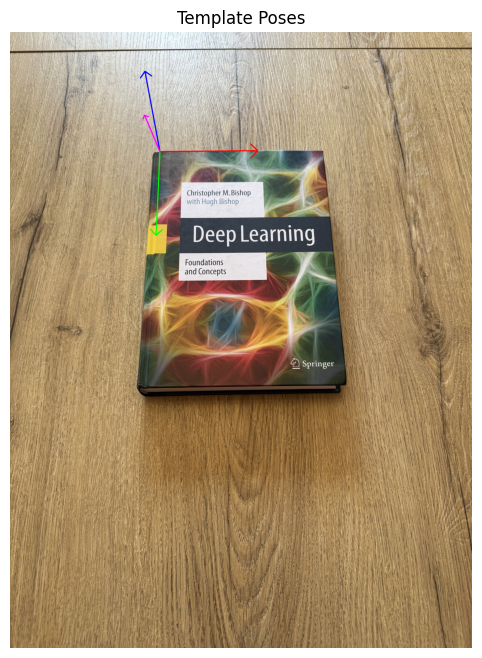

In [11]:
results = run_pipeline(data, load_rgb(os.path.join(project_root, image_dir, image_name)), ['T5'], ground_truth_z)

In [12]:
# Load focal lengths
focal_length = focal_lengths.item().get(image_name, None)
print(f"Focal length for {image_name}: {focal_length:.2f} px")

Focal length for IMG_8222.jpg: 4968.59 px


In [17]:
f_mm = 6.765
image_width = 5712
sensor_width_mm = 7.3

f_px = (f_mm / sensor_width_mm) * image_width
print(f"Computed focal length: {f_px:.2f} px")

Computed focal length: 5293.38 px


In [15]:
1 / 1.28

0.78125